In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# Import training dataset

data_type = {
            'listing_id': int,
            'name': str,
             'street': str,
             'type': str,
             'model': str,
             'market_segment': str,
             'type_of_area': str,
             'bedrooms': str,
             'bathrooms': float,
             'district': int,
             'region': str,
             'planning_area': str,
             'subszone': str,
             'lat': float,
             'lng': float,
             'tenure': str,
             'built_year': float,
             'no_of_units': float,
             'area_size': float,
             'eco_category': str,
             'accessibility': str,
             'date_listed': str,
             'price': int}

train_set = pd.read_csv("Data/train.csv", dtype=data_type)


# Make a copy
train_set_copy = train_set.copy()

# New Section

In [3]:
# Take a glance on dataset
train_set_copy.head(5)

,listing_id,name,street,type,model,market_segment,type_of_area,bedrooms,bathrooms,district,...,lat,lng,tenure,built_year,no_of_units,area_size,eco_category,accessibility,date_listed,price
0,6998418,seascape,57 cove way,condominium,condominium,ocr,strata,3,4.0,4,...,1.239337,103.837487,leasehold/99 years,2011.0,151.0,2336.0,uncategorized,guarded,2021-05-04,5390000
1,2046604,la maison,10 moulmein rise,apartment,apartment,ocr,strata,3,3.0,11,...,1.319533,103.847030,freehold,1999.0,24.0,1259.0,uncategorized,guarded,2021-05-07,2310000
2,7563513,viva,2 suffolk walk,condominium,condominium,ocr,strata,4,3.0,11,...,1.315656,103.844445,freehold,2012.0,235.0,1959.0,uncategorized,guarded,2021-06-30,5279500
3,3071445,urban treasures,205 jalan eunos,condominium,condominium,ocr,strata,3,2.0,14,...,1.329367,103.905791,freehold,NaN,237.0,883.0,uncategorized,guarded,2022-01-02,1843600
4,9667539,infini at east coast,east coast road,apartment,apartment,ocr,strata,3,3.0,15,...,1.309176,103.911352,freehold,NaN,36.0,1066.0,uncategorized,guarded,2021-12-24,2262700


In [4]:
# Check nan for each column
for col_name, _ in train_set_copy.iteritems():
    if len(train_set_copy[train_set_copy[col_name].isna()])>0:
        print("%s: %s rows" % (col_name, len(train_set_copy[train_set_copy[col_name].isna()])))

model: 1280 rows
bedrooms: 404 rows
bathrooms: 1236 rows
tenure: 287 rows
built_year: 10043 rows
no_of_units: 1042 rows
area_size: 2 rows


In [5]:
# Deal with NaN data

#transformaing bedrooms, i.e: from 2+1 to 3
train_set_copy['bedrooms']=train_set_copy['bedrooms'].apply(lambda x: x if type(x)==float else eval(x))

# Get median for three columns: bathrooms, built_year, no_of_units
bedroom_median = np.median(train_set_copy['bedrooms'].dropna())
bathroom_median = np.median(train_set_copy['bathrooms'].dropna())
built_year_median = np.median(train_set_copy['built_year'].dropna())
no_of_units_median = np.median(train_set_copy['no_of_units'].dropna())

print("bedroom_median: ", bedroom_median)
print("bathroom_median: ", bathroom_median)
print("built_year_median: ", built_year_median)
print("no_of_units_median: ", no_of_units_median)

train_set_copy['bedrooms'].fillna(value=bedroom_median, inplace=True)
train_set_copy['bathrooms'].fillna(value=bathroom_median, inplace=True)
train_set_copy['built_year'].fillna(value=built_year_median, inplace=True)
train_set_copy['no_of_units'].fillna(value=no_of_units_median, inplace=True)

# Check column 'tenure', treat houses that are not 'freehold' as 'leasehold', also fill NaN with 'leasehold'
train_set_copy['tenure'].where(train_set_copy['tenure']=='freehold', other='leasehold', inplace=True)

# Drop rows whose area_size is NaN
train_set_copy.dropna(axis=0, subset=['area_size'], inplace=True)


bedroom_median:  3.0
bathroom_median:  2.0
built_year_median:  2014.0
no_of_units_median:  366.0


In [6]:
# Convert some string columns to 0-1 verctors

# Type
type_mapping = {'apartment': 0 ,'condominium' : 1}
train_set_copy['type'] = train_set_copy['type'].map(type_mapping)

# Tenure
tenure_mapping = {'freehold':0 ,'leasehold' : 1}
train_set_copy['tenure'] = train_set_copy['tenure'].map(tenure_mapping)


# For 'build_year', use 2022 - original year to get current age of houses
train_set_copy['built_year'] = 2022 - train_set_copy['built_year']

# For no_of_units, divide all houses into 10 categories, manually set lowest limit=0 and highest limit=10000
cut_bins = np.zeros(shape=(11,))
cut_bins = np.quantile(train_set_copy['no_of_units'], [0.1*i for i in range(11)])
cut_labels = [(cut_bins[i] + cut_bins[i+1])/2 for i in range(10)]
cut_bins[0], cut_bins[-1] = 0, 10000000
train_set_copy['no_of_units'] = pd.cut(train_set_copy['no_of_units'], bins=cut_bins, labels=cut_labels, include_lowest=True).values

# Transfer name, street, region and planning area to numerical values
name_mapping = {label:idx for idx,label in enumerate(set(train_set_copy['name']))}
street_mapping = {label:idx for idx,label in enumerate(set(train_set_copy['street']))}
region_mapping = {'north-east region': 0,
                 'north region': 1,
                 'west region': 2,
                 'east region': 3,
                 'central region': 4}
planning_area_mapping = {label:idx for idx,label in enumerate(set(train_set_copy['planning_area']))}

train_set_copy['name'] = train_set_copy['name'].map(name_mapping)
train_set_copy['street'] = train_set_copy['street'].map(street_mapping)
train_set_copy['region'] = train_set_copy['region'].map(region_mapping)
train_set_copy['planning_area'] = train_set_copy['planning_area'].map(planning_area_mapping)

In [8]:
# Take a glance of dataset after data preprocessing
train_set_copy.reset_index(drop=True, inplace=True)
train_set_copy.head(3)

,listing_id,name,street,type,model,market_segment,type_of_area,bedrooms,bathrooms,district,...,lat,lng,tenure,built_year,no_of_units,area_size,eco_category,accessibility,date_listed,price
0,6998418,1021,2840,1,condominium,ocr,strata,3.0,4.0,4,...,1.239337,103.837487,1,11.0,138.5,2336.0,uncategorized,guarded,2021-05-04,5390000
1,2046604,225,2648,0,apartment,ocr,strata,3.0,3.0,11,...,1.319533,103.847030,0,23.0,28.5,1259.0,uncategorized,guarded,2021-05-07,2310000
2,7563513,87,571,1,condominium,ocr,strata,4.0,3.0,11,...,1.315656,103.844445,0,10.0,217.0,1959.0,uncategorized,guarded,2021-06-30,5279500


In [9]:
# Check correlation between 'price' and other columns
print(train_set_copy.corr(method='pearson')['price'])

listing_id      -0.000812
name            -0.074755
street          -0.065088
type             0.017215
bedrooms         0.430928
bathrooms        0.523360
district        -0.219530
region           0.196188
planning_area    0.010799
lat             -0.233974
lng             -0.066018
tenure          -0.126546
built_year       0.008851
area_size        0.869712
price            1.000000
Name: price, dtype: float64


Column name: district


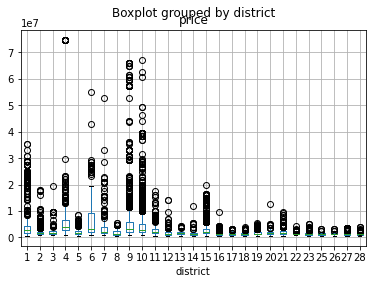

Column name: region


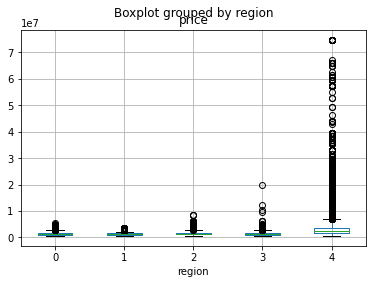

In [10]:
for col_name in ['district', 'region']:
    print("Column name: %s" % (col_name))
    
    # Box plot
    train_set_copy.boxplot(column='price', by=col_name)
    plt.show()

In [11]:
# Import auxiliary data
commercial_centres = pd.read_csv("Data/auxiliary-data/sg-commerical-centres.csv")
hawker_centres = pd.read_csv("Data/auxiliary-data/sg-gov-markets-hawker-centres.csv")
primary_schools = pd.read_csv("Data/auxiliary-data/sg-primary-schools.csv")
secondary_schools = pd.read_csv("Data/auxiliary-data/sg-secondary-schools.csv")
shopping_malls = pd.read_csv("Data/auxiliary-data/sg-shopping-malls.csv")
stations = pd.read_csv("Data/auxiliary-data/sg-train-stations.csv")


In [12]:
# Calculate distance in km with lat & lng
def haversine_batch(train_lng, train_lat, place_lng, place_lat):  # lng1，lat1，lng2，lat2
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    place_lat = np.radians(place_lat)
    place_lng = np.radians(place_lng)

    train_lat = np.radians(train_lat)
    train_lng = np.radians(train_lng)

    dlat = place_lat - train_lat
    dlng = place_lng - train_lng

    a = np.sin(dlat / 2) ** 2 + np.cos(train_lat) * np.cos(place_lat) * np.sin(dlng / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of the earth in km
    return c * r


def cal_distance(X, is_train: bool):
    # Find distance to nearest facilities for each house
    facilities = [commercial_centres, hawker_centres, primary_schools, secondary_schools, shopping_malls, stations]

    res = []

    for f in facilities:

        distance = np.full((len(X), 1), np.inf)

        for _, row in f.iterrows():
            d = haversine_batch(X['lng'].values, X['lat'].values, row['lng'], row['lat']).reshape(-1, 1)
            distance = np.minimum(distance, d)
        
        res.append(distance)
        
    if is_train:
        res.append(X['price'].values.reshape(-1, 1))
        pd_distance = pd.DataFrame(data=np.squeeze(np.asarray(res)).swapaxes(0, 1),
                              columns=['to_commercial_centres', 'to_hawker_centres', 'to_primary_schools',
                                       'to_secondary_schools', 'to_shopping_malls', 'to_train_stations', 'price'])
    else:
        pd_distance = pd.DataFrame(data=np.squeeze(np.asarray(res)).swapaxes(0, 1),
                          columns=['to_commercial_centres', 'to_hawker_centres', 'to_primary_schools',
                                   'to_secondary_schools', 'to_shopping_malls', 'to_train_stations'])
    return pd_distance

In [13]:
# Find distance
train_distance = cal_distance(train_set_copy, is_train=True)
# Discover correlations between price to each other parameter
print(train_distance.corr(method='pearson')['price'])

to_commercial_centres    0.020541
to_hawker_centres        0.006066
to_primary_schools       0.189241
to_secondary_schools     0.196791
to_shopping_malls       -0.061559
to_train_stations        0.020612
price                    1.000000
Name: price, dtype: float64


In [14]:
# Show pd_distance
train_distance.reset_index(drop=True, inplace=True)
train_distance.head(3)

,to_commercial_centres,to_hawker_centres,to_primary_schools,to_secondary_schools,to_shopping_malls,to_train_stations,price
0,5.604095,4.079855,4.064895,4.429845,3.218556,3.409821,5390000.0
1,0.407610,0.519457,0.235428,1.263926,0.339015,0.370228,2310000.0
2,0.498692,0.648320,0.294793,1.075413,0.201332,0.536424,5279500.0


In [15]:
# Option 1: train dataset without "distance" information
# X_train_without_auxiliary_data = train_set_copy[['type', 'bedrooms', 'bathrooms', 'district', 'lat', 'lng', 'tenure', 'built_year', 'no_of_units', 'area_size']]
train_without_auxiliary_data = train_set_copy[['type', 'bedrooms', 'bathrooms', 'region', 'tenure', 'built_year', 'no_of_units', 'area_size', 'price']]
train_without_auxiliary_data.head(3)

,type,bedrooms,bathrooms,region,tenure,built_year,no_of_units,area_size,price
0,1,3.0,4.0,4,1,11.0,138.5,2336.0,5390000
1,0,3.0,3.0,4,0,23.0,28.5,1259.0,2310000
2,1,4.0,3.0,4,0,10.0,217.0,1959.0,5279500


In [16]:
# Option 2: train dataset with "distance" information
train_plus_auxiliary_data = pd.concat([train_set_copy[['type', 'bedrooms', 'bathrooms', 'region', 'tenure', 'built_year', 'no_of_units', 'area_size']], train_distance.iloc[:, :-1], train_set_copy['price']], axis=1)
train_plus_auxiliary_data.head(3)

,type,bedrooms,bathrooms,region,tenure,built_year,no_of_units,area_size,to_commercial_centres,to_hawker_centres,to_primary_schools,to_secondary_schools,to_shopping_malls,to_train_stations,price
0,1,3.0,4.0,4,1,11.0,138.5,2336.0,5.604095,4.079855,4.064895,4.429845,3.218556,3.409821,5390000
1,0,3.0,3.0,4,0,23.0,28.5,1259.0,0.407610,0.519457,0.235428,1.263926,0.339015,0.370228,2310000
2,1,4.0,3.0,4,0,10.0,217.0,1959.0,0.498692,0.648320,0.294793,1.075413,0.201332,0.536424,5279500


In [17]:
all_data = train_plus_auxiliary_data
region_split_points = [0,1,2,3,4]
print("Data distribution:")
#region 0~4
region_set_0=all_data[all_data['region']==region_split_points[0]]
print("region0: ", len(region_set_0))
region_set_1=all_data[all_data['region']==region_split_points[1]]
print("region1: ", len(region_set_1))
region_set_2=all_data[all_data['region']==region_split_points[2]]
print("region2: ", len(region_set_2))
region_set_3=all_data[all_data['region']==region_split_points[3]]
print("region3: ", len(region_set_3))
region_set_4=all_data[all_data['region']==region_split_points[4]]
print("region4: ", len(region_set_4))

Data distribution:
region0:  2793
region1:  855
region2:  2173
region3:  2558
region4:  17667


# Model Training

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
import joblib
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

In [19]:
region_train_list = [region_set_0, region_set_1, region_set_2, region_set_3, region_set_4]

## GBDT

In [20]:
class GBDT_model():
    def __init__(self, **kwargs):
        self.loss = kwargs.get('loss', 'ls')
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.max_depth = kwargs.get('max_depth', 2)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.max_leaf_nodes = kwargs.get('max_leaf_nodes', None)
        self.min_samples_leaf = kwargs.get('min_samples_leaf', 3)
        self.min_samples_split = kwargs.get('min_samples_split', 5)
        self.alpha = kwargs.get('alpha', 0.9)

    def opt_hyper_grid(self, x, y, param_space, num_sets: int=5):

        print('Finding best hyper-parameters for the model...')
        estimator = GradientBoostingRegressor(loss=self.loss, learning_rate=self.learning_rate,
                                              subsample=self.subsample, max_depth=self.max_depth,
                                              n_estimators=self.n_estimators,
                                              max_leaf_nodes=self.max_leaf_nodes,
                                              min_samples_leaf=self.min_samples_leaf,
                                              min_samples_split=self.min_samples_split,
                                              alpha=self.alpha)
        # Cross-validation
        gbdt = GridSearchCV(estimator=estimator, 
                            param_grid=param_space, 
                            cv=KFold(n_splits=num_sets, shuffle=True), 
                            scoring='neg_root_mean_squared_error')
        grid_result = gbdt.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']

        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = gbdt.best_params_
        print('Best params set:', best_params)
        print('Minimum root mean squared error:', -np.max(means))
        print('---------------------------------------------------')
        
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.subsample = best_params.get('subsample', self.subsample)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.max_leaf_nodes = best_params.get('max_leaf_nodes', self.max_leaf_nodes)
        self.min_samples_leaf = best_params.get('min_samples_leaf', self.min_samples_leaf)
        self.min_samples_split = best_params.get('min_samples_split', self.min_samples_split)
        self.alpha = best_params.get('alpha', self.alpha)

        return 


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.subsample = params.get('subsample', self.subsample)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.max_leaf_nodes = params.get('max_leaf_nodes', self.max_leaf_nodes)
            self.min_samples_leaf = params.get('min_samples_leaf', self.min_samples_leaf)
            self.min_samples_split = params.get('min_samples_split', self.min_samples_split)
            self.alpha = params.get('alpha', self.alpha)

        gbdt = GradientBoostingRegressor(loss=self.loss, learning_rate=self.learning_rate,
                                         subsample=self.subsample, max_depth=self.max_depth,
                                         n_estimators=self.n_estimators,
                                         max_leaf_nodes=self.max_leaf_nodes,
                                         min_samples_leaf=self.min_samples_leaf,
                                         min_samples_split=self.min_samples_split, alpha=self.alpha)
        # 10-folder cross-validation
        sk = KFold(n_splits=10, shuffle=True)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            gbdt.fit(train_x, train_y)
            pred_train_gbdt = gbdt.predict(train_x)
            pred_val_gbdt = gbdt.predict(val_x)

            score_train = mean_squared_error(train_y, pred_train_gbdt, squared=False)
            scores_train.append(score_train)
            score_val = mean_squared_error(val_y, pred_val_gbdt, squared=False)
            scores_val.append(score_val)

        print('Train root mean squared error:', np.mean(scores_train))
        print('Val root mean squared error:', np.mean(scores_val))

        return gbdt, np.mean(scores_train), np.mean(scores_val)

In [81]:
# Grid search hyperparameters for each model
train_error = 0
val_error = 0
save_model = True

for i in range(len(region_train_list)):
    print("=========== Set %d ===========" % i)
    samples_weight = len(region_train_list[i]) / len(train_set_copy)
    X_train = region_train_list[i].iloc[:, :-1]
    Y_train = region_train_list[i].iloc[:, -1]
    
    task = GBDT_model()

    params = {
        'learning_rate': [0.3, 0.4,0.45],
        'max_depth': [2, 4],
        'min_samples_leaf': [10, 30,50],
        'n_estimators': [150, 300, 500]

    }

    gbdt_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
    if save_model:
        save_path = "Models/Region_models/gbdt_region_" + str(i) + ".pkl"
        joblib.dump(gbdt_reg, save_path)

    print("Weight: %.3f" % samples_weight)
    train_error += scores_train * samples_weight
    val_error += scores_val * samples_weight

print("*" * 30)
print("Overall train root mean squared error: %.10f" % train_error)
print("Overall val root mean squared error: %.10f" % val_error)

=========== Set 0 ===========
Finding best hyper-parameters for the model...
-154172.689901  with:   {'learning_rate': 0.3, 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 150}
-147082.947040  with:   {'learning_rate': 0.3, 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 300}
-143263.707227  with:   {'learning_rate': 0.3, 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 500}
-158921.093077  with:   {'learning_rate': 0.3, 'max_depth': 2, 'min_samples_leaf': 30, 'n_estimators': 150}
-151547.115547  with:   {'learning_rate': 0.3, 'max_depth': 2, 'min_samples_leaf': 30, 'n_estimators': 300}
-147649.164097  with:   {'learning_rate': 0.3, 'max_depth': 2, 'min_samples_leaf': 30, 'n_estimators': 500}
-170371.186223  with:   {'learning_rate': 0.3, 'max_depth': 2, 'min_samples_leaf': 50, 'n_estimators': 150}
-162879.892055  with:   {'learning_rate': 0.3, 'max_depth': 2, 'min_samples_leaf': 50, 'n_estimators': 300}
-159925.059020  with:   {'learning_rate': 0.3, 'max_depth':

In [21]:
# Fine tune model for a specific training subset

save_model = False
training_set = 2     # Choose from 0~12
X_train = region_train_list[training_set].iloc[:, :-1]
Y_train = region_train_list[training_set].iloc[:, -1]
samples_weight = len(region_train_list[training_set]) / len(train_set_copy)

task = GBDT_model()

params = {'learning_rate': 0.3, 
          'max_depth': 4,
          'min_samples_leaf': 10,
          'n_estimators': 500
         }
# {'learning_rate': 0.5, 'max_depth': 4, 'min_samples_leaf': 50, 'n_estimators': 300}
gbdt_reg, _, _ = task.build_model(X_train, Y_train, params, grid_search=False)

if save_model:
    save_path = "Models/Region_models/gbdt_region_" + str(training_set) + ".pkl"
    joblib.dump(gbdt_reg, save_path)

print("Weight: %.3f" % samples_weight)

Train root mean squared error: 72241.75351038977
Val root mean squared error: 157348.6950838803
Weight: 0.083


## Xgboost

In [22]:
class XGBoost_model():
    def __init__(self, **kwargs):
        self.objective = kwargs.get('objective', 'reg:squarederror')
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.max_depth = kwargs.get('max_depth', 3)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.booster = kwargs.get('booster', 'gbtree')
        self.gamma = kwargs.get('gamma', 0)
        self.reg_alpha = kwargs.get('reg_alpha', 0)
        self.reg_lambda = kwargs.get('reg_lambda', 1)

    def opt_hyper_grid(self, x, y, param_space, num_sets: int=5):

        print('Finding best hyper-parameters for the model...')
        estimator = xgb.XGBRegressor(objective=self.objective, max_depth=self.max_depth,
                                     learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                     subsample=self.subsample, booster=self.booster, n_jobs=-1, gamma=self.gamma,
                                     reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda)
        xgb_try = GridSearchCV(estimator=estimator, param_grid=param_space, cv=KFold(n_splits=num_sets, shuffle=True), scoring='neg_root_mean_squared_error')
        grid_result = xgb_try.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']
        
        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = xgb_try.best_params_
        print('Best params set:', best_params)
        print('Minimum root mean squared error: ', -np.max(means))
        print('---------------------------------------------------')
        
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.subsample = best_params.get('subsample', self.subsample)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.booster = best_params.get('booster', self.booster)
        self.gamma = best_params.get('gamma', self.gamma)
        self.reg_alpha = best_params.get('reg_alpha', self.reg_alpha)
        self.reg_lambda = best_params.get('alpha', self.reg_lambda)

        return 


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.subsample = params.get('subsample', self.subsample)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.booster = params.get('booster', self.booster)
            self.gamma = params.get('gamma', self.gamma)
            self.reg_alpha = params.get('reg_alpha', self.reg_alpha)
            self.reg_lambda = params.get('alpha', self.reg_lambda)

        xgb_reg = xgb.XGBRegressor(objective=self.objective, max_depth=self.max_depth,
                                   learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                   subsample=self.subsample, booster=self.booster, gamma=self.gamma,
                                   n_jobs=-1, reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda)
        
        # 10-folder cross validation
        sk = KFold(n_splits=5, shuffle=True)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            xgb_reg.fit(train_x, train_y)
            pred_train_xgb = xgb_reg.predict(train_x)
            pred_val_xgb = xgb_reg.predict(val_x)

            score_train = mean_squared_error(train_y, pred_train_xgb, squared=False)
            scores_train.append(score_train)
            score_val = mean_squared_error(val_y, pred_val_xgb, squared=False)
            scores_val.append(score_val)

        print('Train root mean squared error:', np.mean(scores_train))
        print('Val root mean squared error:', np.mean(scores_val))

        return xgb_reg, np.mean(scores_train), np.mean(scores_val)

In [26]:
# Grid search hyperparameters for each model
train_error = 0
val_error = 0
save_model = True


for i in range(len(region_train_list)):
    print("=========== Set %d ===========" % i)
    samples_weight = len(region_train_list[i]) / len(train_set_copy)
    X_train = region_train_list[i].iloc[:, :-1]
    X_train['no_of_units'] = X_train['no_of_units'].astype('float32')
    Y_train = region_train_list[i].iloc[:, -1]
    
    task = XGBoost_model()

    params = {'learning_rate': [0.3, 0.5, 0.6, 0.7],
              'n_estimators': [150, 300, 500, 700],
              'max_depth':[3, 4, 5]

    }

    xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
    if save_model:
        save_path = "Models/Region_models/xgboost_region_" + str(i) + ".pkl"
        joblib.dump(xgb_reg, save_path)

    print("Weight: %.3f" % samples_weight)
    train_error += scores_train * samples_weight
    val_error += scores_val * samples_weight

print("*" * 30)
print("Overall train root mean squared error: %.10f" % train_error)
print("Overall val root mean squared error: %.10f" % val_error)

=========== Set 0 ===========
Finding best hyper-parameters for the model...
-144761.520622  with:   {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 150}
-141212.786793  with:   {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}
-141019.309056  with:   {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500}
-140932.534197  with:   {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 700}
-144439.482787  with:   {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 150}
-143962.150278  with:   {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 300}
-145319.197124  with:   {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 500}
-146415.378945  with:   {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 700}
-141093.490913  with:   {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 150}
-141987.540981  with:   {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300}
-143381.882360  with:   {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 500}

In [23]:
# Fine tune model for a specific training subset

save_model = False
training_set = 3      # Choose from 0~4

X_train = region_train_list[training_set].iloc[:, :-1]
X_train['no_of_units'] = X_train['no_of_units'].astype('float32')
Y_train = region_train_list[training_set].iloc[:, -1]

samples_weight = len(region_train_list[training_set]) / len(train_set_copy)

task = XGBoost_model()

params = {'learning_rate': 0.2, 
          'n_estimators': 800,
          'max_depth': 6
}

xgb_reg, _, _ = task.build_model(X_train, Y_train, params, grid_search=False)

if save_model:
    save_path = "Models/Region_models/xgboost_region_" + str(training_set) + ".pkl"
    joblib.dump(xgb_reg, save_path)

print("Weight: %.3f" % samples_weight)

Train root mean squared error: 35337.49331929957
Val root mean squared error: 321648.892126541
Weight: 0.098


## LightGBM

In [24]:
class LightGBM_model():
    def __init__(self, **kwargs):
        self.boosting_type = kwargs.get('boosting_type', 'gbdt')
        self.num_leaves = kwargs.get('num_leaves', 16)
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.subsample_for_bin = kwargs.get('subsample_for_bin', 200000)
        self.max_depth = kwargs.get('max_depth', 3)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.min_split_gain = kwargs.get('min_split_gain', 0.0)
        self.min_child_samples = kwargs.get('min_child_samples', 20)
        self.reg_alpha = kwargs.get('reg_alpha', 0)
        self.reg_lambda = kwargs.get('reg_lambda', 1)
        

    def opt_hyper_grid(self, x, y, param_space, num_sets: int=5):

        print('Finding best hyper-parameters for the model...')
        estimator = lgb.LGBMRegressor(boosting_type=self.boosting_type, num_leaves=self.num_leaves, 
                                      max_depth=self.max_depth, learning_rate=self.learning_rate, 
                                      n_estimators=self.n_estimators, subsample_for_bin=self.subsample_for_bin, 
                                      min_split_gain=self.min_split_gain, min_child_samples=self.min_child_samples, 
                                      subsample=self.subsample, reg_alpha=self.reg_alpha, 
                                      reg_lambda=self.reg_lambda, n_jobs=-1)
        lgb_try = GridSearchCV(estimator=estimator, 
                               param_grid=param_space, 
                               cv=KFold(n_splits=num_sets, shuffle=True), 
                               scoring='neg_root_mean_squared_error')
        grid_result = lgb_try.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']
        
        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = lgb_try.best_params_
        print('Best params set:', best_params)
        print('Minimum root mean squared error:', -np.max(means))
        print('---------------------------------------------------')
        self.boosting_type = best_params.get('boosting_type', self.boosting_type)
        self.num_leaves = best_params.get('num_leaves', self.num_leaves)
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.subsample = best_params.get('subsample', self.subsample)
        self.subsample_for_bin = best_params.get('subsample_for_bin', self.subsample_for_bin)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.min_split_gain = best_params.get('min_split_gain', self.min_split_gain)
        self.min_child_samples = best_params.get('min_child_samples', self.min_child_samples)
        self.reg_alpha = best_params.get('reg_alpha', self.reg_alpha)
        self.reg_lambda = best_params.get('reg_lambda', self.reg_lambda)

        return 


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.boosting_type = params.get('boosting_type', self.boosting_type)
            self.num_leaves = params.get('num_leaves', self.num_leaves)
            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.subsample = params.get('subsample', self.subsample)
            self.subsample_for_bin = params.get('subsample_for_bin', self.subsample_for_bin)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.min_split_gain = params.get('min_split_gain', self.min_split_gain)
            self.min_child_samples = params.get('min_child_samples', self.min_child_samples)
            self.reg_alpha = params.get('reg_alpha', self.reg_alpha)
            self.reg_lambda = params.get('reg_lambda', self.reg_lambda)

        lgb_reg = lgb.LGBMRegressor(boosting_type=self.boosting_type, num_leaves=self.num_leaves, 
                                      max_depth=self.max_depth, learning_rate=self.learning_rate, 
                                      n_estimators=self.n_estimators, subsample_for_bin=self.subsample_for_bin, 
                                      min_split_gain=self.min_split_gain, min_child_samples=self.min_child_samples, 
                                      subsample=self.subsample, reg_alpha=self.reg_alpha, 
                                      reg_lambda=self.reg_lambda, n_jobs=- 1)
        # 10-folder cross validation
        sk = KFold(n_splits=5, shuffle=True)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            lgb_reg.fit(train_x, train_y)
            pred_train_lgb = lgb_reg.predict(train_x)
            pred_val_lgb = lgb_reg.predict(val_x)

            score_train = mean_squared_error(train_y, pred_train_lgb, squared=False)
            scores_train.append(score_train)
            score_val = mean_squared_error(val_y, pred_val_lgb, squared=False)
            scores_val.append(score_val)

        print('Train root mean squared error:', np.mean(scores_train))
        print('Val root mean squared error:', np.mean(scores_val))

        return lgb_reg, np.mean(scores_train), np.mean(scores_val)

In [21]:
# Grid search hyperparameters for each model
train_error = 0
val_error = 0
save_model = True

for i in range(len(region_train_list)):
    print("=========== Set %d ===========" % i)
    samples_weight = len(region_train_list[i]) / len(train_set_copy)
    X_train = region_train_list[i].iloc[:, :-1]
    Y_train = region_train_list[i].iloc[:, -1]
    
    task = LightGBM_model()

    params = {
        'learning_rate': [0.3, 0.5, 0.7],
        'n_estimators': [200, 300, 500],
        'max_depth':[3, 4],
        'min_child_samples': [60, 100],
        'num_leaves': [16, 32]
    }

    lgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
    if save_model:
        save_path = "Models/Region_models/lightgbm_region_" + str(i) + ".pkl"
        joblib.dump(lgb_reg, save_path)

    print("Weight: %.3f" % samples_weight)
    train_error += scores_train * samples_weight
    val_error += scores_val * samples_weight

print("*" * 30)
print("Overall train root mean squared error: %.10f" % train_error)
print("Overall val root mean squared error: %.10f" % val_error)
# kaggle_X_test = X_test_plus_auxiliary_data

=========== Set 0 ===========
Finding best hyper-parameters for the model...
-165998.078271  with:   {'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 60, 'n_estimators': 200, 'num_leaves': 16}
-165998.078271  with:   {'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 60, 'n_estimators': 200, 'num_leaves': 32}
-164439.938288  with:   {'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 60, 'n_estimators': 300, 'num_leaves': 16}
-164439.938288  with:   {'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 60, 'n_estimators': 300, 'num_leaves': 32}
-162961.372611  with:   {'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 60, 'n_estimators': 500, 'num_leaves': 16}
-162961.372611  with:   {'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 60, 'n_estimators': 500, 'num_leaves': 32}
-173175.115031  with:   {'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 100, 'n_estimators': 200, 'num_leaves': 16}
-173175.115031  with:   {'learnin

In [25]:
# Fine tune model for a specific training subset

save_model = False
training_set = 0      # Choose from 0~12
X_train = region_train_list[training_set].iloc[:, :-1]
Y_train = region_train_list[training_set].iloc[:, -1]
samples_weight = len(region_train_list[training_set]) / len(train_set_copy)

task = LightGBM_model()

params = {'learning_rate': 0.5, 
          'min_child_samples': 20,
          'min_split_gain': 0, 
          'n_estimators': 300}


lgb_reg, _, _ = task.build_model(X_train, Y_train, params, grid_search=False)

if save_model:
    save_path = "Models/Region_models/lightgbm_region_" + str(training_set) + ".pkl"
    joblib.dump(lgb_reg, save_path)

print("Weight: %.3f" % samples_weight)

Train root mean squared error: 75522.02845572727
Val root mean squared error: 142000.3111049977
Weight: 0.107


## Test with Kaggle test set

In [26]:
# Import test dataset
data_type = {
            'listing_id': int,
            'name': str,
             'street': str,
             'type': str,
             'model': str,
             'market_segment': str,
             'type_of_area': str,
             'bedrooms': str,
             'bathrooms': float,
             'district': int,
             'region': str,
             'planning_area': str,
             'subszone': str,
             'lat': float,
             'lng': float,
             'tenure': str,
             'built_year': float,
             'no_of_units': float,
             'area_size': float,
             'eco_category': str,
             'accessibility': str,
             'date_listed': str
             }

test_set = pd.read_csv("Data/test.csv", dtype=data_type)


# Make a copy
test_set_copy = test_set.copy()

test_set_copy.head(3)

# Check nan for each column
for col_name, _ in test_set_copy.iteritems():
    if len(test_set_copy[test_set_copy[col_name].isna()])>0:
        print("%s: %s rows" % (col_name, len(test_set_copy[test_set_copy[col_name].isna()])))

model: 388 rows
bedrooms: 118 rows
bathrooms: 337 rows
tenure: 85 rows
built_year: 2875 rows
no_of_units: 326 rows


In [27]:
def convert_test_set(X_test):
    # Data preprocessing for test data set
    
    #transformaing bedrooms, i.e: from 2+1 to 3
    X_test['bedrooms']=X_test['bedrooms'].apply(lambda x: x if type(x)==float else eval(x))
    
    # Deal with NaN data
    X_test['bedrooms'].fillna(value=bedroom_median, inplace=True)
    X_test['bathrooms'].fillna(value=bathroom_median, inplace=True)
    X_test['built_year'].fillna(value=built_year_median, inplace=True)
    X_test['no_of_units'].fillna(value=no_of_units_median, inplace=True)

    # Check column 'tenure', treat houses that are not 'freehold' as 'leasehold', also fill NaN with 'leasehold'
    X_test['tenure'].where(X_test['tenure']=='freehold', other='leasehold', inplace=True)

    # Drop rows whose area_size is NaN
    X_test.dropna(axis=0, subset=['area_size'], inplace=True)
    
    # Convert some string columns to 0-1 verctors
    # Type
    type_mapping = {'apartment': 0 ,'condominium' : 1}
    X_test['type'] = X_test['type'].map(type_mapping)
    # Tenure
    tenure_mapping = {'freehold':0 ,'leasehold' : 1}
    X_test['tenure'] = X_test['tenure'].map(tenure_mapping)
    
    # For 'build_year', use 2022 - original year to get current age of houses
    X_test['built_year'] = 2022 - X_test['built_year']

    # For no_of_units, divide all houses into 10 categories, manually set lowest limit=0 and highest limit=10000
    X_test['no_of_units'] = pd.cut(X_test['no_of_units'], bins=cut_bins, labels=cut_labels, include_lowest=True).values
    
    # Convert name, street, region and planning area to numerical values
    X_test['name'] = X_test['name'].map(name_mapping)
    X_test['street'] = X_test['street'].map(street_mapping)
    X_test['region'] = X_test['region'].map(region_mapping)
    X_test['planning_area'] = X_test['planning_area'].map(planning_area_mapping)


    return

In [28]:
convert_test_set(test_set_copy)
test_set_copy.reset_index(drop=True, inplace=True)
test_set_copy.head(3)

,listing_id,name,street,type,model,market_segment,type_of_area,bedrooms,bathrooms,district,...,subszone,lat,lng,tenure,built_year,no_of_units,area_size,eco_category,accessibility,date_listed
0,1487111,968.0,144.0,1,condominium,ocr,strata,2.0,2.0,10,...,farrer court,1.313566,103.803218,0,8.0,630.0,710.0,uncategorized,guarded,2021-12-12
1,6794066,571.0,1146.0,1,condominium,ocr,strata,3.0,2.0,15,...,tanjong rhu,1.298437,103.884408,0,6.0,138.5,1055.0,uncategorized,guarded,2021-10-12
2,4027017,59.0,680.0,0,apartment,ocr,strata,3.0,1.0,15,...,frankel,1.317851,103.908905,0,9.0,138.5,463.0,uncategorized,guarded,2021-12-23


In [29]:
test_distance = cal_distance(test_set_copy, is_train=False)
test_distance.reset_index(drop=True, inplace=True)

In [30]:
# Option 1: Test set without "distance" information
# X_test_without_auxiliary_data = test_set_copy[['type', 'bedrooms', 'bathrooms', 'district', 'lat', 'lng', 'tenure', 'built_year', 'no_of_units', 'area_size']]
X_test_without_auxiliary_data = test_set_copy[['type', 'bedrooms', 'bathrooms', 'region', 'tenure', 'built_year', 'no_of_units', 'area_size']]
X_test_without_auxiliary_data.head(3)

,type,bedrooms,bathrooms,region,tenure,built_year,no_of_units,area_size
0,1,2.0,2.0,4,0,8.0,630.0,710.0
1,1,3.0,2.0,4,0,6.0,138.5,1055.0
2,0,3.0,1.0,3,0,9.0,138.5,463.0


In [31]:
# Option 2: Test set with "distance" information
X_test_plus_auxiliary_data = pd.concat([X_test_without_auxiliary_data, test_distance], axis=1)
# X_test_plus_auxiliary_data = pd.concat([X_test_without_auxiliary_data, test_distance[['to_primary_schools', 'to_secondary_schools']]], axis=1)
X_test_plus_auxiliary_data.head(3)

,type,bedrooms,bathrooms,region,tenure,built_year,no_of_units,area_size,to_commercial_centres,to_hawker_centres,to_primary_schools,to_secondary_schools,to_shopping_malls,to_train_stations
0,1,2.0,2.0,4,0,8.0,630.0,710.0,1.659712,0.410398,0.980559,1.048619,1.128913,0.654270
1,1,3.0,2.0,4,0,6.0,138.5,1055.0,2.415213,0.446516,1.469982,0.249159,0.969806,0.888254
2,0,3.0,1.0,3,0,9.0,138.5,463.0,1.712861,0.587265,0.893951,1.343460,1.475109,0.572349


In [32]:
# Predict
model_dict = {
    0: "gbdt",
    1: "xgboost",
    2: "lightgbm"

}

region_model_index = 0
model_root_path = "Models/Region_models/" + model_dict[region_model_index]

region_model_0 = joblib.load(model_root_path + "_region_0.pkl")
region_model_1 = joblib.load(model_root_path + "_region_1.pkl")
region_model_2 = joblib.load(model_root_path + "_region_2.pkl")
region_model_3 = joblib.load(model_root_path + "_region_3.pkl")
region_model_4 = joblib.load(model_root_path + "_region_4.pkl")

kaggle_Y_pred = np.zeros(shape=(len(X_test_plus_auxiliary_data),))
# region_split_points = [0,1,2,3,4]
region_models = [region_model_0, region_model_1, region_model_2, region_model_3, region_model_4]

for i in range(len(X_test_plus_auxiliary_data)):
    sample_input = X_test_plus_auxiliary_data.iloc[i,:]
    sample_region = sample_input['region']
    sample_input = sample_input.values.reshape(1, -1)
    
    
    isFound = False
    for j in range(len(region_models)-2):
        if region_split_points[j] <= sample_region < region_split_points[j+1]:
            kaggle_Y_pred[i] = region_models[j].predict(sample_input)
            isFound = True
            break
    if not isFound:
        kaggle_Y_pred[i] = region_models[-1].predict(sample_input)

In [33]:
kaggle_Y_pred

array([2055458.6727038 , 2580772.05927016, 1315008.02445301, ...,
       1635095.99756091,  826517.76531074, 7725628.78500246])

In [ ]:
pred_df = pd.Series(kaggle_Y_pred, name='Predicted')
# print(len(pred_df)) 

# Save the results
sava_root_path = "Results/Region_model_results/" + model_dict[model_index] + "_"
pred_df.to_csv(sava_root_path + "gs_with_aux.csv", header=['Predicted'], index_label=['Id'])